In [1]:
import cv2
import numpy as np
#import imutils
import math
import os
#import imutils
import random
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from PIL import Image
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
from scipy import signal
from scipy import misc

# METHODS

In [14]:
# detect and extract features from the image
def detectAndDescribe( image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    descriptor = cv2.xfeatures2d.SIFT_create()
    (kps, features) = descriptor.detectAndCompute(image, None)
    kps = np.float32([kp.pt for kp in kps])
    return kps, features

def matchKeypoints(kpsA, kpsB, features1, features2, ratio, threshold):
    # compute the raw matches and initialize the list of actual matches
    distances,rawMatches = matchFeatures(features1,features2)

    matches = []

    for i in range (len(rawMatches)):
        # Lowe's ratio test
        if distances[i][0] < distances[i][1] * ratio :
            matches.append((rawMatches[i][0],i))
    # computing a homography requires at least 4 matches
    #print("Number of matches found is : " + str(len(matches)))

    if len(matches) > 4:
        # construct the two sets of points
        ptsA = np.float32([kpsA[i] for (_, i) in matches])
        ptsB = np.float32([kpsB[i] for (i, _) in matches])
        # compute the homography between the two sets of points
        print("computing homography")
        #Own implemented homography
        (H,status) = findHomography(ptsA, ptsB)
        #This calculates cv2 homography. 
        #(H1, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, threshold)#TODO delete this
        #print(H)
        #print(H1)
        return (matches, H,status)
    return None

def matchFeatures(features1, features2, k = 2):
    # print("feature shape  is " + str(features1.shape))
    disc=[]
    indx = []
    for i,feat1 in enumerate(features1):
        distances = []
        for j,feat2 in enumerate(features2):
            #find the mean of the features distances
            distances.append((np.linalg.norm(feat1-feat2),j))
        # Smallest K elements indices using sorted() + lambda + list slicing 
        distances.sort()
        disc.append([d for d,x in distances[:k]])
        indx.append([y for d,y in distances[:k]])
        # print('calculating the descriptor = {} is done'.format(i))

    return (disc,indx)


def findHomography(ptsA,ptsB, MAXITER = 40000):
        
        #Initilaze the variables
        H = np.ones([9,1])
        points1 = ptsA
        points2 = ptsB
        bestH = np.ones([9,1])
        ransacsize = 4 #How many points we take for the subset
        MSE = 999999999 #keep track of minumum error ( LEAST SQUARED ERROR)

        #RANSAC runs MAXITER times. 
        for i in range (MAXITER):

            #Report the current minimal error to track if we are doing better solutions
            #if (i % 1000) == 0:
                #print(str(i)+"th iteration")
                #print("MSE is currently min : " +str(MSE)) 
            homo = []
            h = np.ones([9,1])
            rn = np.random.randint(len(points1), size=ransacsize)
            A = points1[rn,:]
            B = points2[rn,:]

            # Get and Normalize coordinates:
            x1 = A[:,0]
            y1 = A[:,1]
            x2 = B[:,0]
            y2 = B[:,1]
            
            # Self Construction
            # Find the homography matrix between A and B.
            for i in range(len(A)):
                homo.append([x1[i], y1[i], 1, 0, 0, 0, (-1*x1[i]*x2[i]), (-1*y1[i]*x2[i]), (-1*x2[i])])
                homo.append([0, 0, 0, x1[i], y1[i], 1, (-1*x1[i]*y2[i]), (-1*y1[i]*y2[i]), (-1*y2[i])])
            
            #Construct one homography matrix by using singular value construction
            _,_,V = np.linalg.svd(homo)
            h = V[-1,:]
            #Normalize the homography matrix so that the last element is one.
            h = [x/h[8] for x  in h ] 
            H = np.reshape(h, (3,3))

            #Start testing the homography matrix
            error = 0
            # Test is for only half of the points. Because we may have outliers which would cause wrong
            # matchings if they increase the error.
            rn2 = np.random.randint(len(points1), size=(int(len(points1)/2)))
            test_p1= points1[rn2,:]
            test_p2 = points2[rn2,:]
            for hi in range(len(test_p1)):
                x = test_p1[hi,0]
                y = test_p1[hi,1]
                
                #Calculate the transformed points with homography matrix
                denum = ((H[2][0] * x )+ (H[2][1] * y) + 1)
                x_ = (H[0][0] * x + H[0][1] * y + H[0][2]) / denum
                y_ = (H[1][0] * x + H[1][1] * y + H[1][2]) / denum
                #Least squared errors, to decide if we are generalizing the homography for the data.
                error += (test_p2[hi,0]-x_)**2 + (test_p2[hi,1]-y_)**2
                
            if error < MSE: 
                MSE = error
                bestH = H

        return bestH, True

    
    
def warpPerspective(src_image,H,distance):
    height,width = distance
    print("Distance input is "+ str (distance))
    result = np.zeros((height*3,width*3,3), np.uint8)

    for y in range(src_image.shape[0]):
        for x in range(src_image.shape[1]):
            denum = (H[2][0] * x )+ (H[2][1] * y) + 1
            # TODO : fix possible lose of information
            x_1 = math.floor( (H[0][0] * x + H[0][1] * y + H[0][2])/ denum )
            y_1 = math.floor( (H[1][0] * x + H[1][1] * y + H[1][2])/ denum )
            x_2 = math.ceil( (H[0][0] * x + H[0][1] * y + H[0][2])/ denum )
            y_2 = math.ceil( (H[1][0] * x + H[1][1] * y + H[1][2])/ denum )

            if(all(v == 0 for v in result[y_1,x_1,:])):
                result[y_1,x_1,:] = src_image[y,x,:]
            elif(all(v == 0 for v in result[y_1,x_2,:])):
                result[y_1,x_2,:] = src_image[y,x,:]
            elif(all(v == 0 for v in result[y_2,x_1,:])):
                result[y_2,x_1,:] = src_image[y,x,:]
            elif(all(v == 0 for v in result[y_2,x_2,:])):
                result[y_2,x_2,:] = src_image[y,x,:]
            else:
                result[y_1,x_1,:] = src_image[y,x,:]
    print("Warped image's shape : " + str(result.shape))
    return result

def disparity_correlation_classic(image1, image2, m):
    """ Computes the disparity for image 1 using image 2
    
    m = length of the square filter. 
    
    returns:
    disparity_map: disparity map for image 1
    """
    
    if image1.shape != image2.shape:
        print('Dimensions do not match')
        return False, None
    if m%2 == 0:
        print('Only odd dimentional filters')
        return False, None

    p = math.floor(m/2) #specify padding

    V,H,C = image1.shape
    #im1 = np.zeros((l + 2*padding, w + 2*padding,c))

    im2 = np.pad(image2,(( p, p),( p, p),(0,0)),'constant',constant_values = (0,0)) 
    im1 = np.pad(image1,(( p, p),( p, p),(0,0)),'constant',constant_values = (0,0)) 


    disparity_map = np.zeros((V,H))


    for i in range(V):   #vertical
        u = i + p
        disp = 0
        for j in range(H): #horizontal
            v = j + p

            W1 = im1[ u-p : u+p+1, v-p : v+p+1, :]#Extract window
            W1 = W1/np.linalg.norm(W1)            #Normalize
            max_corr = -1                          #initialize maximum correlation

            for k in range(H):
                l = k+p

                W2 = im2[ u-p : u+p+1, l-p : l-p+1, :]
                W2 = W2/np.linalg.norm(W2)

                curr_corr = np.sum(W2*W1)

                if curr_corr > max_corr:
                    max_corr = curr_corr
                    disp = v-l

            disparity_map[i,j] = disp

    return True, disparity_map

def disparity_correlation_smart(image1, image2, m, treshold, neighborhood):
    """ Computes the disparity for image 1 using image 2
    
    m = length of the square filter. 
    condfidence = minimum treshold to match points
    neighborhood = horizontal neoigborhood in each direction to search at. 
    
    returns:
    False/True: found the map or not
    disparity_map: disparity map for image 1
    """
    

    F = neighborhood

    if image1.shape != image2.shape:
        print('Dimensions do not match')
        return False, None
    if m%2 == 0:
        print('Only odd dimentional filters')
        return False, None

    p = math.floor(m/2) #specify padding

    V,H,C = image1.shape
    #im1 = np.zeros((l + 2*padding, w + 2*padding,c))

    im2 = np.pad(image2,(( p, p),( p, p),(0,0)),'constant',constant_values = (0,0)) 
    im1 = np.pad(image1,(( p, p),( p, p),(0,0)),'constant',constant_values = (0,0)) 


    disparity_map = np.zeros((V,H))

    for i in range(1,V-1):   #vertical
        u = i + p
        disp = 0
        for j in range(H): #horizontal
            v = j + p

            W1 = im1[ u-p : u+p+1, v-p : v+p+1, :]#Extract window
            W1 = W1/np.linalg.norm(W1)            #Normalize
            max_corr = -1                          #initialize maximum correlation
            #disp = 0

            if v + F > H :
                hor_max_lim = H
            else:
                hor_max_lim = j + F

            if v - F < p:
                hor_min_lim = p
            else:
                hor_min_lim = j - F

            for k in range(hor_min_lim, hor_max_lim):
                l = k+p

                W21 = im2[ u-p - 1 : u+p+1 - 1, l-p : l-p+1, :]
                W21 = W21/np.linalg.norm(W21)
                W22 = im2[ u-p : u+p+1, l-p : l-p+1, :]
                W22 = W22/np.linalg.norm(W22)
                W23 = im2[ u-p + 1 : u+p+1 + 1, l-p : l-p+1, :]
                W23 = W23/np.linalg.norm(W23)


                curr_corr1 = np.sum( W21*W1)
                curr_corr2 = np.sum( W22*W1)
                curr_corr3 = np.sum( W23*W1)

                curr_corr = max( curr_corr1, curr_corr2, curr_corr3)

                if curr_corr > max_corr and curr_corr > treshold:
                    max_corr = curr_corr
                    disp = v - l

            disparity_map[i,j] = disp

        #print(i)
    return True, disparity_map


def disparity_max_classic(image1, image2, m):
    """ Computes the disparity for image 1 using image 2
    
    m = length of the square filter. 
    
    returns:
    disparity_map: disparity map for image 1
    """
    
    if image1.shape != image2.shape:
        print('Dimensions do not match')
        return False, None
    if m%2 == 0:
        print('Only odd dimentional filters')
        return False, None

    p = math.floor(m/2) #specify padding

    V,H,C = image1.shape
    #im1 = np.zeros((l + 2*padding, w + 2*padding,c))

    im2 = np.pad(image2,(( p, p),( p, p),(0,0)),'constant',constant_values = (0,0)) 
    im1 = np.pad(image1,(( p, p),( p, p),(0,0)),'constant',constant_values = (0,0)) 


    disparity_map = np.zeros((V,H))

    for i in range(V):   #vertical
        u = i + p
        for j in range(H): #horizontal
            v = j + p

            W1 = im1[ u-p : u+p+1, v-p : v+p+1, :]#Extract window
            W1 = W1/np.linalg.norm(W1)            #Normalize
            max_loss = math.inf                    #initialize maximum loss
            disp = 0

            for k in range(H):
                l = k+p

                W2 = im2[ u-p : u+p+1, l-p : l-p+1, :]
                W2 = W2/np.linalg.norm(W2)


                curr_loss = np.max(np.abs(W2-W1))

                if curr_loss < max_loss:
                    max_loss = curr_loss
                    disp = j - k

            disparity_map[i,j] = disp

        #print(i)
    return True, disparity_map

def blend(img1, img2, alpha):
    """ Blends 2 images
    
    alpha = blending ration
    
    returns:
    img3: blended image
    """
        
    img3 = (img1*alpha + img2*(1-alpha))
    return img3

 # TESTING


In [4]:

img_cloth_1 = cv2.imread('data_disparity_estimation/Cloth1/view1.png') # queryImage
img_cloth_5 = cv2.imread('data_disparity_estimation/Cloth1/view5.png') # trainImage

img_plastic_1 = cv2.imread('data_disparity_estimation/Plastic/view1.png') # queryImage
img_plastic_5 = cv2.imread('data_disparity_estimation/Plastic/view5.png') # queryImage

#detect cloth keypoints
kp_c1, f_c1 = detectAndDescribe(img_cloth_1)
kp_c5, f_c5 = detectAndDescribe(img_cloth_5)

#detect plastic keypoints
kp_p1, f_p1 = detectAndDescribe(img_plastic_1)
kp_p5, f_p5 = detectAndDescribe(img_plastic_5)

computing homography
Distance input is (834, 370)
Warped image's shape : (2502, 1110, 3)


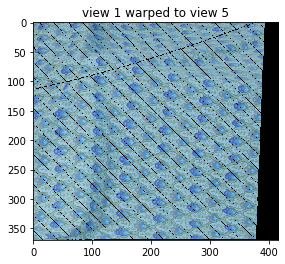

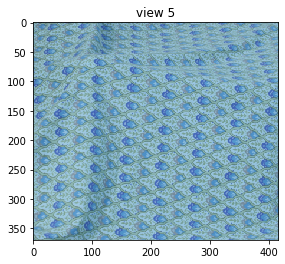

In [56]:
# find mapping from cloth 1 to cloth 5 
matches_c15, H_c15 , stat_c15 = matchKeypoints(kp_c1, kp_c5, f_c1, f_c5, 0.5, 5)

# rectify image 1 wrt 5
res_c15 = warpPerspective(img_cloth_1, H_c15, ( img_cloth_1.shape[1] + img_cloth_5.shape[1], img_cloth_1.shape[0]))
res_c15 = res_c15[:370,:417]

#display results 
plt.figure()
plt.imshow(res_c15)
plt.title('view 1 warped to view 5')
plt.show()
plt.figure()
plt.imshow(img_cloth_5)
plt.title('view 5')
plt.show()

computing homography
Distance input is (834, 370)
Warped image's shape : (2502, 1110, 3)


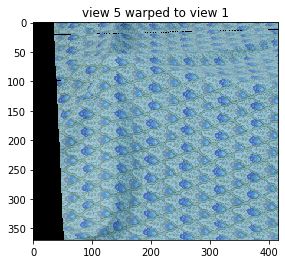

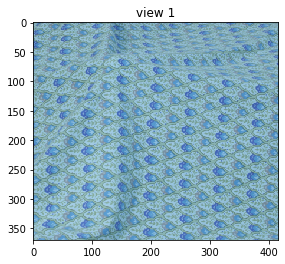

In [63]:
# find mapping from cloth 5 to cloth 1 
matches_c51, H_c51 , stat_c51 = matchKeypoints(kp_c5, kp_c1, f_c5, f_c1, 0.5, 5)

# rectify image 5 wrt 1
res_c51 = warpPerspective(img_cloth_5, H_c51, ( img_cloth_5.shape[1] + img_cloth_1.shape[1], img_cloth_5.shape[0]))
res_c51 = res_c51[:370,:417]

#display results 
plt.figure()
plt.imshow(res_c51)
plt.title('view 5 warped to view 1')
plt.show()
plt.figure()
plt.imshow(img_cloth_1)
plt.title('view 1')
plt.show()

computing homography
Distance input is (846, 370)
Warped image's shape : (2538, 1110, 3)


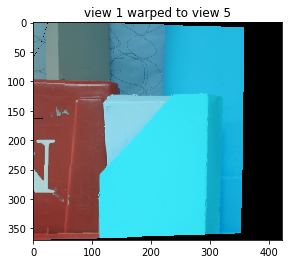

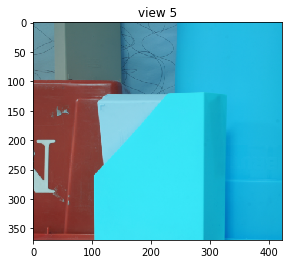

In [7]:
# find mapping from plastic 1 to plastic 5
matches_p15, H_p15 , stat_p15 = matchKeypoints(kp_p1, kp_p5, f_p1, f_p5, 0.5, 7)

# rectify image 1 wrt 5
res_p15 = warpPerspective(img_plastic_1, H_p15, ( img_plastic_1.shape[1] + img_plastic_5.shape[1], img_plastic_1.shape[0]))
res_p15 = res_p15[:370,:423]

plt.figure()
plt.imshow(res_p15)
plt.title('view 1 warped to view 5')
plt.show()
plt.figure()
plt.imshow(img_plastic_5)
plt.title('view 5')
plt.show()

computing homography
Distance input is (846, 370)
Warped image's shape : (2538, 1110, 3)


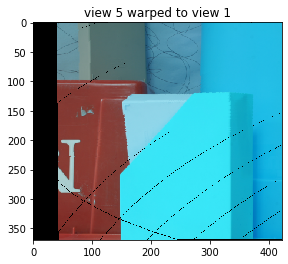

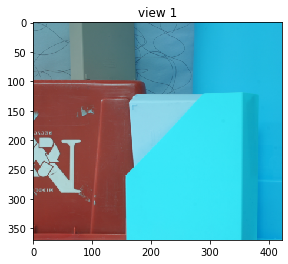

In [8]:
# find mapping from plastic 5 to plastic 1
matches_p51, H_p51 , stat_p51 = matchKeypoints(kp_p5, kp_p1, f_p5, f_p1, 0.5, 7)

# rectify image 5 wrt 1
res_p51 = warpPerspective(img_plastic_5, H_p51, ( img_plastic_5.shape[1] + img_plastic_1.shape[1], img_plastic_5.shape[0]))
res_p51 = res_p51[:370,:423]


plt.figure()
plt.imshow(res_p51)
plt.title('view 5 warped to view 1')
plt.show()
plt.figure()
plt.imshow(img_plastic_1)
plt.title('view 1')
plt.show()

# RUN FROM HERE

In [68]:
import dill
dill.load_session('HOMEWORK_DISPARITY_FOR_SUBMISSION.db')

C:\Users\mirza\Anaconda3\lib\site-packages\ipykernel_launcher.py:262: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mirza\Anaconda3\lib\site-packages\ipykernel_launcher.py:264: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mirza\Anaconda3\lib\site-packages\ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


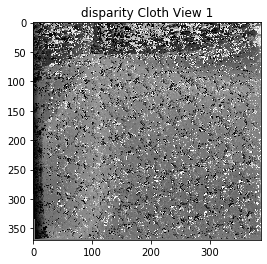

In [69]:
# compute and display disprity of Cloth view 1
_, disp_c1 = disparity_correlation_smart(img_cloth_1, res_c51, 3, 0.3, 20)
plt.figure()
plt.imshow(disp_c1[:,30:], cmap = 'gray')
plt.title('disparity Cloth View 1')
plt.show()

C:\Users\mirza\Anaconda3\lib\site-packages\ipykernel_launcher.py:262: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mirza\Anaconda3\lib\site-packages\ipykernel_launcher.py:264: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mirza\Anaconda3\lib\site-packages\ipykernel_launcher.py:266: RuntimeWarning: invalid value encountered in true_divide


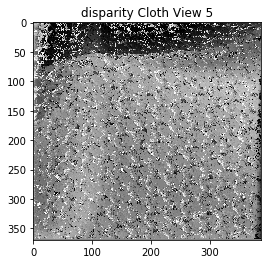

In [59]:
# compute and display disprity of Cloth view 5
_, disp_c5 = disparity_correlation_smart(img_cloth_5, res_c15, 3, 0.1, 15)
plt.figure()
plt.imshow(-1*disp_c5[:,:-30], cmap='gray')
plt.title('disparity Cloth View 5')
plt.show()

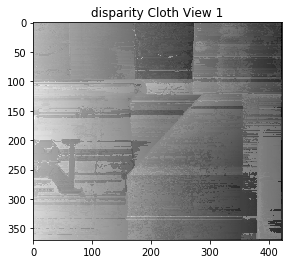

In [43]:
# compute and display disprity of Cloth view 1
_, disp_p1_max = disparity_max_classic(img_plastic_1, res_p51, 3)
_, disp_p1_cor = disparity_correlation_classic(img_plastic_1, res_p51, 3)

plt.figure()
plt.imshow( blend(-1*disp_p1_max,-1*disp_p1_cor,0.7), cmap = 'gray')
plt.title('disparity Cloth View 1')
plt.show()

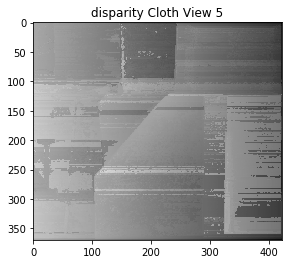

In [53]:
# compute and display disprity of Cloth view 5
_, disp_p5_max = disparity_max_classic(img_plastic_5, res_p15, 3)
_, disp_p5_cor = disparity_correlation_classic(img_plastic_5, res_p15, 3)

plt.figure()
plt.imshow( -1*blend(disp_p5_max, disp_p5_cor,0.8), cmap='gray')
plt.title('disparity Cloth View 5')
plt.show()

In [67]:
# Saves session
import dill
dill.dump_session('HOMEWORK_DISPARITY_FOR_SUBMISSION.db')